# LFR electric potential low pass filter design
## overview
Initially LFR provides electrical potential trough HK packets at 1Hz frequency by decimating F3 dataflow. Then we implemented as moving average to reduce aliasing this turned out to be a poor design choice. 
This notebook will present the LFR IIR filter design used to produce HK potential from F3 datastream.

In [51]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import peakutils
import pandas as pds
plt.rcParams['figure.figsize'] = (14, 10)

## Filter comparaison
We will compare first three filters, **moving average** , **FIR** filter and **IIR** filter.

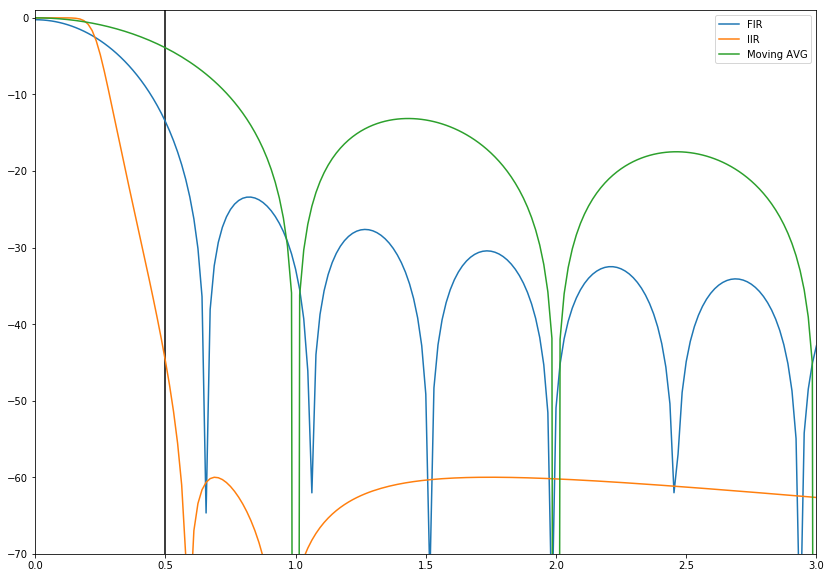

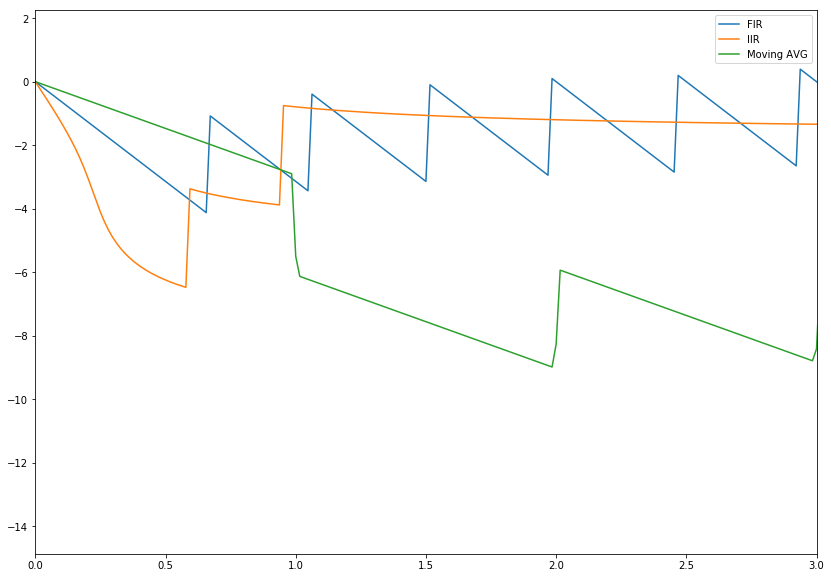

In [52]:
#FIR Filter
coef=signal.firls(33,(0,0.1,0.5,8),(1,1,0,0),nyq=8)
w, h = signal.freqz(coef,whole=False)

#IIR Filter
b, a = signal.iirfilter(5, 0.07, rs=60, btype='lowpass',analog=False, ftype='cheby2')
w_rec, h_rec = signal.freqz(b,a,whole=False)

#Moving average
w_, h_ = signal.freqz(np.ones(16)/16,whole=False)

#plot Gain
plt.plot(w*8/np.pi, 20 * np.log10(abs(h)),label="FIR")
plt.plot(w_rec*8/np.pi, 20 * np.log10(abs(h_rec)),label="IIR")
plt.plot(w_*8/np.pi, 20 * np.log10(abs(h_)),label="Moving AVG")
plt.vlines(0.5,-70,1)
plt.legend()
plt.ylim(-70,1)
plt.xlim(0,3)
plt.show()

#plot phase
plt.plot(w*8/np.pi,  np.unwrap(np.angle(h)),label="FIR")
plt.plot(w_rec*8/np.pi,  np.unwrap(np.angle(h_rec)),label="IIR")
plt.plot(w_*8/np.pi,  np.unwrap(np.angle(h_)),label="Moving AVG")
plt.legend()
plt.xlim(0,3)
plt.show()

With no surprise, the IIR fiter gives the best results with a small amount of computation. But as is this this filter would be quite hard to implement with fixed point arithmetic due to the high dynamic in coeficients and accuracy needs.
We will then try to overcome this issue by transforming this filter in a cascade of 2nd order sections called **SOS**.

In [53]:
print(a)
print(b)

[ 1.         -4.69325121  8.81955512 -8.294829    3.90424534 -0.73571303]
[ 0.00049678 -0.00139622  0.00090303  0.00090303 -0.00139622  0.00049678]


## Flat to SOS conversion

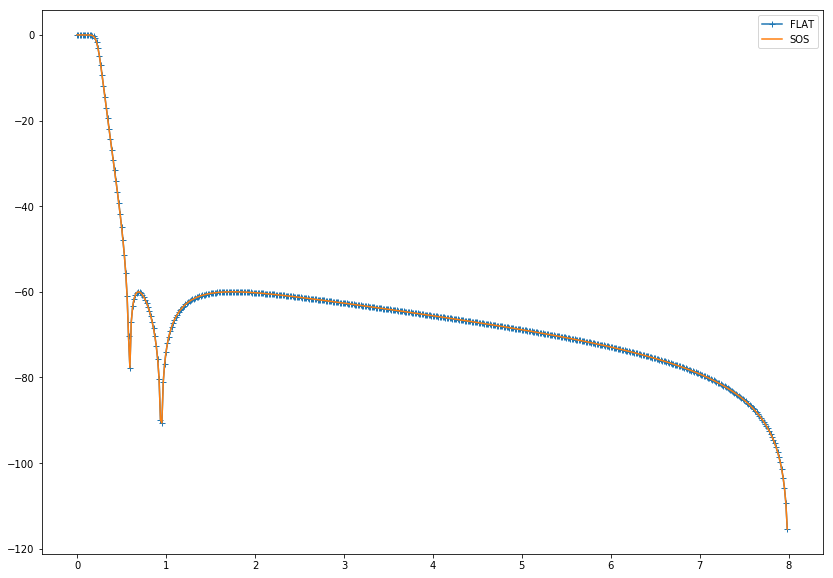

Stage 0 coefs
[ 0.00049678  0.00049678  0.        ]
[ 1.         -0.90347831  0.        ]
Stage 1 coefs
[ 1.         -1.86369503  1.        ]
[ 1.         -1.8493484   0.85823409]
Stage 2 coefs
[ 1.         -1.94681606  1.        ]
[ 1.         -1.94042451  0.94882247]


In [67]:
sos=signal.iirfilter(5, 0.07, rs=60, btype='lowpass',analog=False, ftype='cheby2',output='sos')
b, a = signal.iirfilter(5, 0.07, rs=60, btype='lowpass',analog=False, ftype='cheby2')

w_sos, h_sos = signal.sosfreqz(sos)
w, h = signal.freqz(b,a)

plt.plot(w*8/np.pi, 20 * np.log10(abs(h)),marker='+',label="FLAT")
plt.plot(w_sos*8/np.pi, 20 * np.log10(abs(h_sos)),label="SOS")
plt.legend()
plt.show()

for stage,i in zip(sos,range(len(sos))):
    print("==============================")
    print("Stage {} coefs".format(i))
    print(stage[:3])
    print(stage[3:])
    print("==============================")


As we can see the two filters have the same transfer function but the SOS version has also a limited dynamic among each stage.
We should aslo check if the gain is 0dB for each cell

97.1464739838


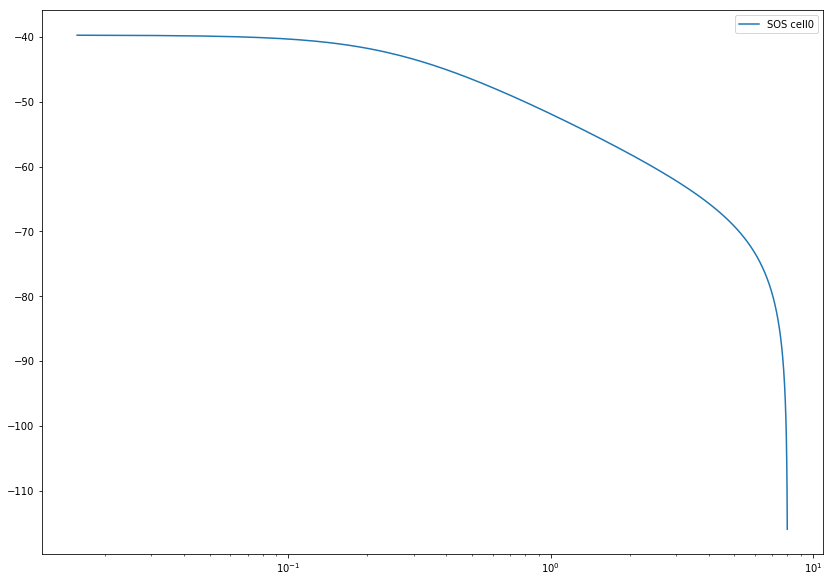

0.0651897732092


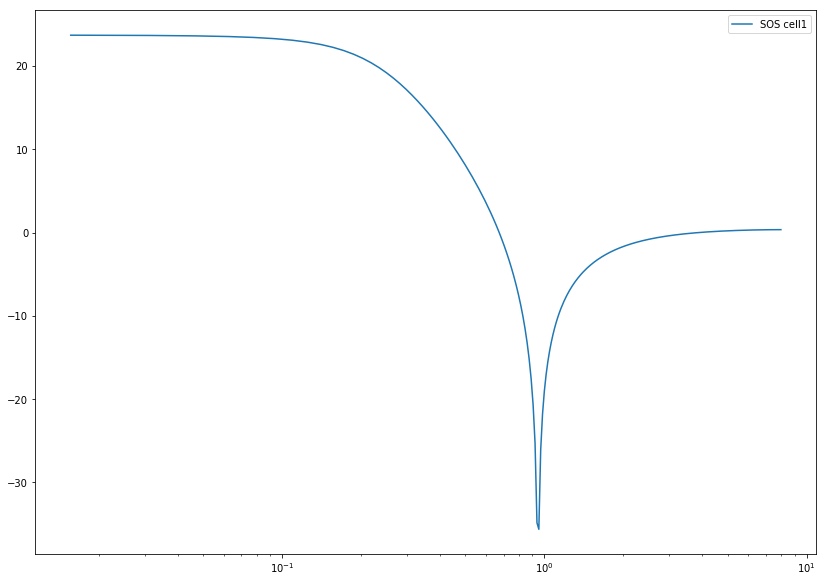

0.0989684499371


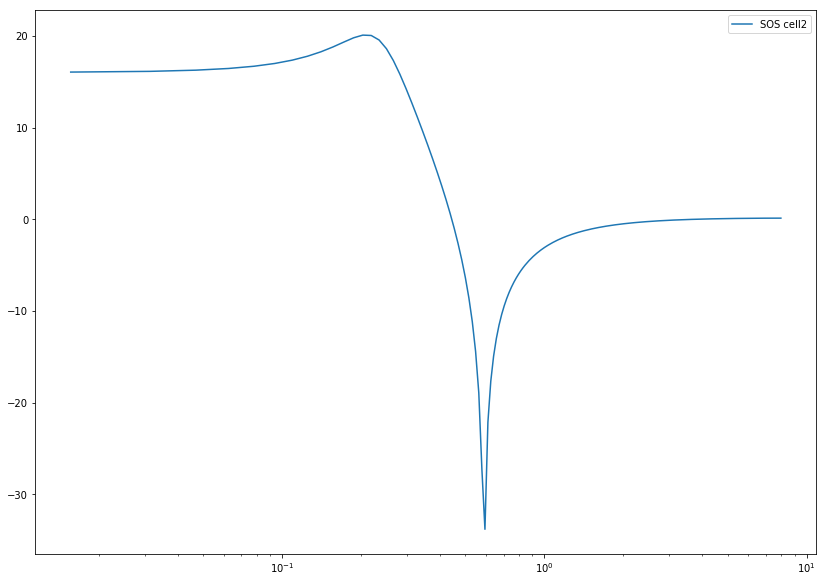

In [68]:
for cel,i in zip(sos,range(len(sos))):
    w_cell, h_cell = signal.sosfreqz([cel])
    plt.plot(w_cell*8/np.pi, 20 * np.log10(abs(h_cell)),label="SOS cell{}".format(i))
    print(1/max(abs(h_cell)))
    plt.semilogx()
    plt.legend()
    plt.show()

The first cell attenuate the signal by 40dB while the two later stages amplifies the signal by 20dB each.

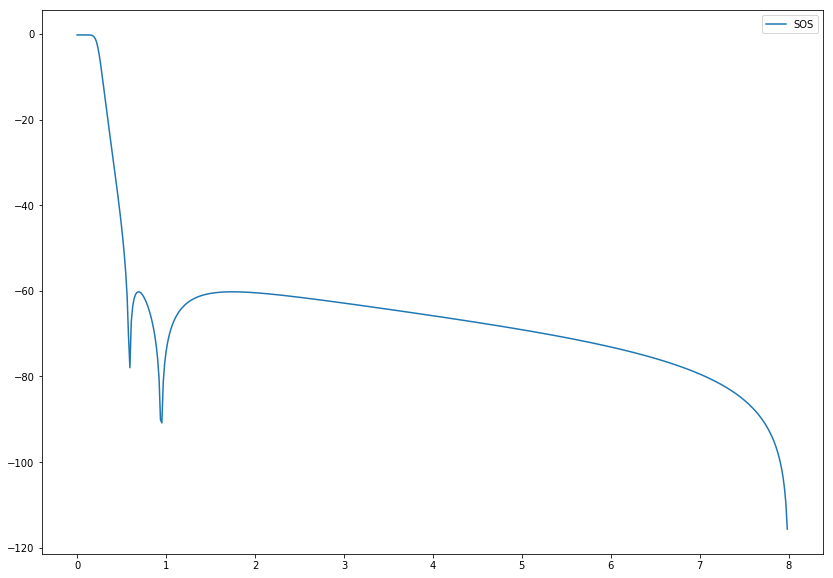

Stage 0 coefs
[ 0.04793969  0.04793969  0.        ]
[ 1.         -0.90347831  0.        ]
Stage 1 coefs
[ 0.064      -0.11927648  0.064     ]
[ 1.         -1.8493484   0.85823409]
Stage 2 coefs
[ 0.1575     -0.30662353  0.1575    ]
[ 1.         -1.94042451  0.94882247]


In [69]:
sos[0][0:3]=sos[0][0:3]*96.5
sos[1][0:3]=sos[1][0:3]*0.064
sos[2][0:3]=sos[2][0:3]*0.1575

w_sos, h_sos = signal.sosfreqz(sos)

plt.plot(w_sos*8/np.pi, 20 * np.log10(abs(h_sos)),label="SOS")
plt.legend()
plt.show()

for stage,i in zip(sos,range(len(sos))):
    print("==============================")
    print("Stage {} coefs".format(i))
    print(stage[:3])
    print(stage[3:])
    print("==============================")

Now we can work on coeficients ronding to convert them as integers.

Stage 0 coefs
[ 0.04785156  0.04785156  0.        ]
[ 1.         -0.90332031  0.        ]
Stage 1 coefs
[ 0.06396484 -0.11914062  0.06396484]
[ 1.         -1.84960938  0.85742188]
Stage 2 coefs
[ 0.15722656 -0.30664062  0.15722656]
[ 1.         -1.93945312  0.94921875]


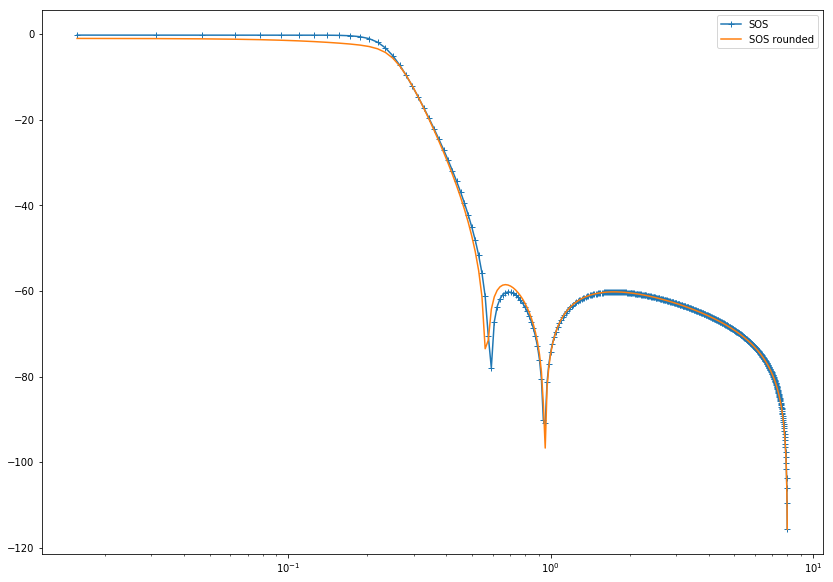

1.01020408163


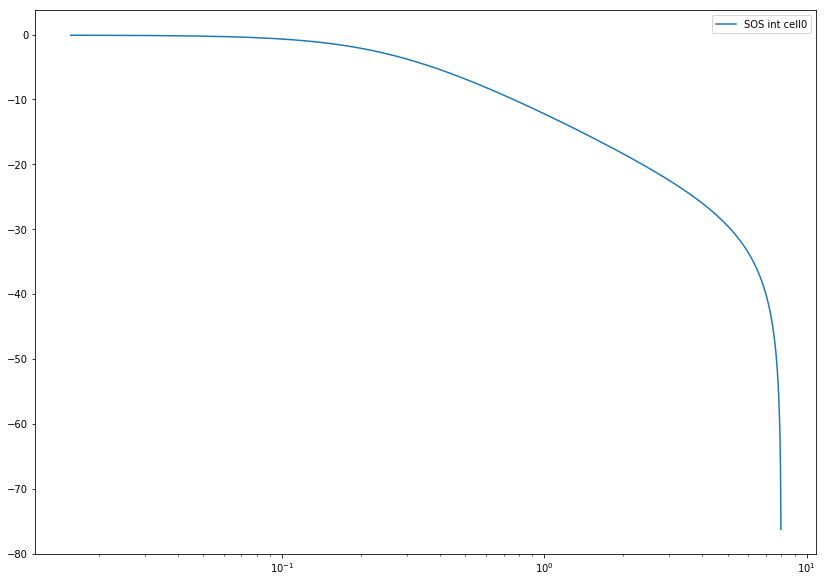

0.888888888889


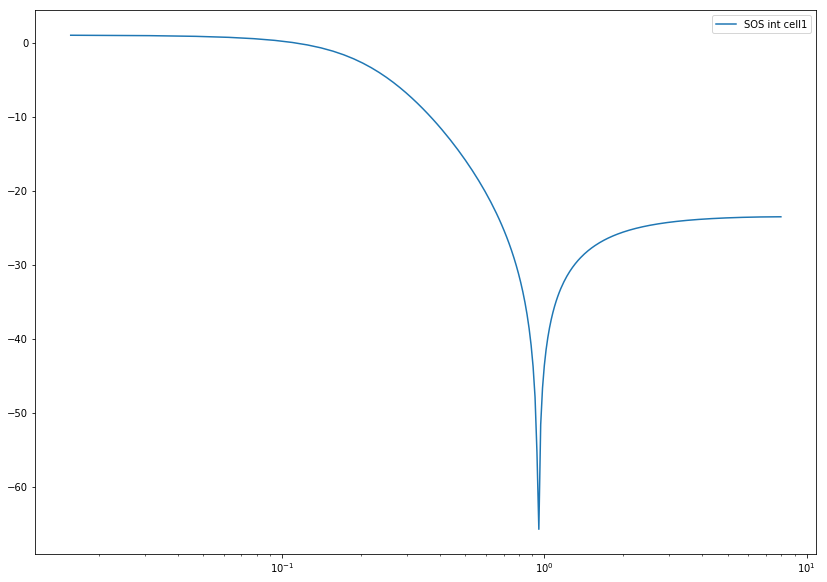

0.75708762513


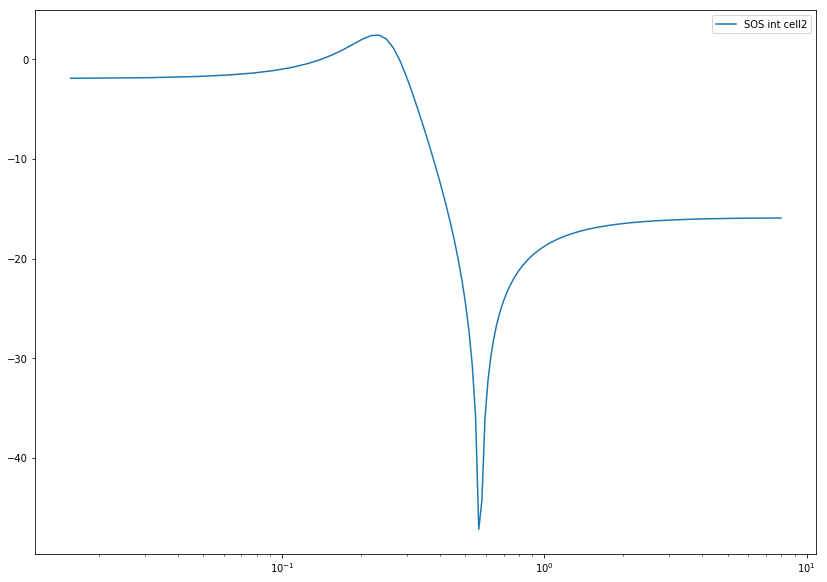

In [112]:
sos_int=sos.copy()
sos_int[0][:3]=np.round(sos[0][:3]*(2**12))/2**12
sos_int[0][4:]=np.round(sos[0][4:]*(2**10))/2**10

sos_int[1][:3]=np.round(sos[1][:3]*(2**11))/2**11
sos_int[1][4:]=np.round(sos[1][4:]*(2**9))/2**9

sos_int[2][:3]=np.round(sos[2][:3]*(2**10))/2**10
sos_int[2][4:]=np.round(sos[2][4:]*(2**9))/2**9

i=0
for stage in sos_int:
    print("==============================")
    print("Stage {} coefs".format(i))
    print(stage[:3])
    print(stage[3:])
    print("==============================")
    i+=1

w_sos_int, h_sos_int = signal.sosfreqz(sos_int)

plt.plot(w_sos*8/np.pi, 20 * np.log10(abs(h_sos)),marker='+',label="SOS")
plt.plot(w_sos_int*8/np.pi, 20 * np.log10(abs(h_sos_int)),label="SOS rounded")
plt.legend()
plt.semilogx()
#plt.ylim(-8,2)
plt.show()

for cel,i in zip(sos_int,range(len(sos_int))):
    w_cell, h_cell = signal.sosfreqz([cel])
    plt.plot(w_cell*8/np.pi, 20 * np.log10(abs(h_cell)),label="SOS int cell{}".format(i))
    print(1/max(abs(h_cell)))
    plt.semilogx()
    plt.legend()
    plt.show()

As we can see we can easily encode coeficients on a 16 bits integer.

In [96]:
sos_int_C=sos.copy()

gains=[(2**12,2**10),(2**11,2**9),(2**10,2**9)]

for i,G in zip(range(3),gains):
    sos_int_C[i][:3]=np.round(sos[i][:3]*G[0])
    sos_int_C[i][4:]=np.round(sos[i][4:]*G[1])
out_b="static const int32_t b[3][3]={"
out_a="static const int32_t a[3][3]={"
out_b_g="static const int32_t b_gain[3]={"
out_a_g="static const int32_t a_gain[3]={"

for stage,G in zip(sos_int_C,gains):
    out_b+= "{" + str(int(stage[0])) +","+ str(int(stage[1])) +","+ str(int(stage[2])) + "},"
    out_a+= "{" + str(int(stage[3])) +","+ str(int(stage[4])) +","+ str(int(stage[5])) + "},"
    out_a_g+=str(int(np.log2(G[1]))) + ","
    out_b_g+=str(int(np.log2(G[0]))) + ","
    
out_b=out_b[:-1]+"};"
out_a=out_a[:-1]+"};"
out_b_g=out_b_g[:-1]+"};"
out_a_g=out_a_g[:-1]+"};"
print(out_b)
print(out_a)
print(out_b_g)
print(out_a_g)

static const int32_t b[3][3]={{196,196,0},{131,-244,131},{161,-314,161}};
static const int32_t a[3][3]={{1,-925,0},{1,-947,439},{1,-993,486}};
static const int32_t b_gain[3]={12,11,10};
static const int32_t a_gain[3]={10,9,9};


Let's compare C implementation impulse response with Python one.

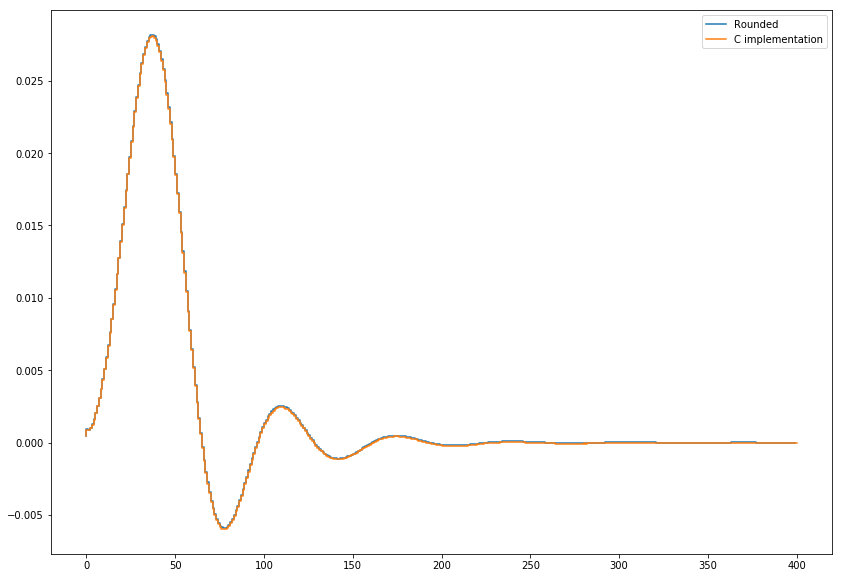

In [120]:
imp=signal.sosfilt(sos_int,signal.unit_impulse(400))
plt.step(np.arange(len(imp)),imp,label="Rounded")
df=pds.read_csv("/home/jeandet/Documents/prog/sparc/build-LFR_POT_Filter-Desktop-Default/test.txt",header=None)
plt.step(df.index,df[0]/(32768),label="C implementation")
plt.legend()
plt.show()

## C filter implementation example

```c

#include <stdio.h>
#include <stdint.h>

static const int32_t b[3][3]={{196,196,0},{131,-244,131},{161,-314,161}};
static const int32_t a[3][3]={{1,-925,0},{1,-947,439},{1,-993,486}};
static const int32_t b_gain[3]={12,11,10};
static const int32_t a_gain[3]={10,9,9};



typedef struct filter_ctx
{
    int32_t W[3][3];
}filter_ctx;

int32_t filter(int32_t x,filter_ctx* ctx)
{
    //Direct-Form-II
    for (int i=0;i<3;i++)
    {
        x=x<<a_gain[i];
        int32_t W=(x - (a[i][1]*ctx->W[i][0]) - (a[i][2]*ctx->W[i][1]))>>a_gain[i];
        x=(b[i][0]*W) + (b[i][1]*ctx->W[i][0]) + (b[i][2]*ctx->W[i][1]);
        x=(x>>(b_gain[i]));
        ctx->W[i][1] = ctx->W[i][0];
        ctx->W[i][0] = W;
    }
    return x;
}

int main(void)
{
    filter_ctx ctx={{{0,0,0},{0,0,0},{0,0,0}}};
    printf("%d\n",filter(32768,&ctx));
    for(int i=0;i<400;i++)
    {
        printf("%d\n",filter(0,&ctx));
    }
}


```